In [1]:
import sys
sys.path.append("../../")
from simulation_classes.flying_cars import FlyingCars
from simulation_classes.simulation_periodic import SimulationPeriodic
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### このファイルでは、Hellyモデルで基本図を書くことを目的とする。



In [2]:
TOTAL_TIME = 100
time_step = 0.2
simulation_steps = int(TOTAL_TIME / time_step)
scale_factor = 30
legal_speed = 1.5
real_legal_speed = min(2, legal_speed) * scale_factor * 3.6
TOTAL_DISTANCE = 40
boundary_condition = "PERIODIC"
UPDATE_RULE = "parallel"
MAX_ACC_REAL_WORLD = 2 # 0.2Gくらい
MIN_ACC_REAL_WORLD = 5 # 0.5Gくらい

print(f"この設定だと法定速度は時速{real_legal_speed}km")
print(f"巡航距離は{TOTAL_DISTANCE * scale_factor /1000}kmです")

この設定だと法定速度は時速162.0km
巡航距離は1.2kmです


In [3]:
DRONE_NUM = 200
v_0 = 0
max_acc = MAX_ACC_REAL_WORLD / scale_factor # ルンゲクッタの時に加速度にdelta_tがかかることに注意
min_acc = MIN_ACC_REAL_WORLD / scale_factor

helly_params = {
    "max_accel": max_acc,
    "min_accel": min_acc,
    "lambda_1": 0.2,
    "lambda_2": 0.4,
    "d": 0.5,
    "T_des": 1,
  }

# 先頭の車が前になるように置く(一番後ろの車はx=0でスタート)
def scatter_cars_around(total_distance, car_num, idx, should_scatter=False):
    delta = total_distance / car_num
    return total_distance - delta * (idx+1)
    

cars_list = [FlyingCars(xcor=scatter_cars_around(TOTAL_DISTANCE, DRONE_NUM, i),
                     ycor=0, 
                     v_0=0,
                     legal_speed=legal_speed, 
                     scale_factor=scale_factor,
                     drone_idx = i,
                     helly_params=helly_params,
                     )
               for i in range(DRONE_NUM)]
print("最大加速度は{:.2f}G".format(MAX_ACC_REAL_WORLD / 9.8))
print("最小加速度は{:.2f}G".format(MIN_ACC_REAL_WORLD / 9.8))
print("平均車間距離は{:.2f}m".format(TOTAL_DISTANCE / DRONE_NUM * scale_factor))

最大加速度は0.20G
最小加速度は0.51G
平均車間距離は6.00m


In [4]:
simulation = SimulationPeriodic(
    TOTAL_TIME=TOTAL_TIME, 
    time_step=time_step, 
    scale_factor=scale_factor,
    drone_list=cars_list,
    TOTAL_DISTANCE=TOTAL_DISTANCE,
    UPDATE_RULE=UPDATE_RULE )

In [5]:
simulation.run()


===PARALLEL実行===
FINISHED


In [6]:
# ここからは結果の吟味

simulation.show_FD()


AttributeError: 'SimulationPeriodic' object has no attribute 'show_FD'

200


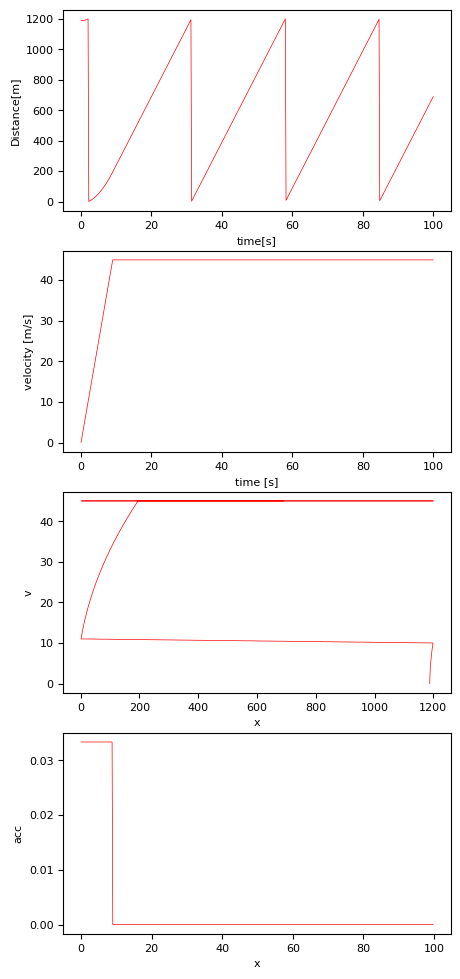

In [9]:
print(len(simulation.drone_list))
drone_1 = simulation.drone_list[1]
drone_1.plot_history_scaled(time_step, scale_factor)

In [26]:
print("ここから動画を作る")

ここから動画を作る


In [30]:
import cv2
import os

color_list=["orange","pink","blue","brown","red","green"]
images = []
frames = simulation.simulation_steps
drones = simulation.drone_list

radius = 4


for i in range(frames):
    if (i%4 ==1):
        continue
    plt.figure(figsize=(4,4))
    for (droneNum, drone) in enumerate(drones):
        theta = drone.xcorList[int(i)] /TOTAL_DISTANCE * 2 * np.pi
        if (droneNum == 0):
            plt.scatter(radius *np.cos(theta), radius * np.sin(theta), color=color_list[droneNum%6], s=6)
        else:
            plt.scatter(radius * np.cos(theta), radius * np.sin(theta), color=color_list[droneNum%6], s=6)
    plt.xlim(-1*(radius + 1 ) , radius + 1 )
    plt.ylim(-1*(radius + 1 ) , radius + 1 )
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8)
    # plt.xlabel("Distance", fontsize=8)
    # plt.ylabel("Height", fontsize=8)
    plt.savefig(f"tmp/frame_{i}.png")
    plt.close()

    filename = 'tmp/frame_{}.png'.format(i)
    img = cv2.imread(filename)
    images.append(img)
    os.remove(f"tmp/frame_{i}.png")
    if (i%100 == 0):
        print(f"frame_{i}__Done")

print("動画作成開始")
output_file = f'tmp/output_circular_DroneNum={DRONE_NUM}.mp4'
fps = 10
size = (images[0].shape[1], images[0].shape[0])

# 動画を保存するためのオブジェクトを生成する
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_file, fourcc, fps, size)

# 100枚の画像を動画に書き込む
for i in range(len(images)):
    out.write(images[i])

# 動画を保存するための処理を終了する
out.release()
print("END")

frame_0__Done
frame_100__Done
frame_200__Done
frame_300__Done
frame_400__Done
動画作成開始


OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


END
